<a href="https://colab.research.google.com/github/dhyan1999/DL_ML/blob/master/Caltech101_Resnet50_DataAugmentation%2BEncoderDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install patool pyunpack
import pyunpack
pyunpack.Archive("/content/drive/MyDrive/images/Dataset.rar").extractall("/content/dataset")

     |████████████████████████████████| 81kB 5.5MB/s 


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
import math
os.mkdir("caltech_test") # stores test data

for cat in os.listdir("/content/dataset/Caltech101/"):
  # moves x portion of images per category into test images
  os.mkdir("caltech_test/"+cat) # new category folder
  imgs = os.listdir("/content/dataset/Caltech101/"+cat) # all image filenames
  test_imgs = imgs[30:len(imgs)]
  for t_img in test_imgs: # move test portion
    os.rename("/content/dataset/Caltech101/"+cat+"/"+t_img, "caltech_test/"+cat+"/"+t_img)

In [ ]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)

In [ ]:
from keras.applications.resnet50 import preprocess_input 

train_gen_autoencoder = ImageDataGenerator(rescale=1./255) 
train_flow = train_gen_autoencoder.flow_from_directory("/content/dataset/Caltech101/", target_size=(256, 256), batch_size=64,class_mode=None)
valid_flow = train_gen_autoencoder.flow_from_directory("/content/dataset/Caltech101/", target_size=(256, 256), batch_size=64,class_mode=None)

Found 3060 images belonging to 102 classes.
Found 3060 images belonging to 102 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [ ]:
model = models.Sequential()

# Encoder Layer
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same') )


# Decoder Layer
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)) )
model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same') )

In [ ]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
model.fit_generator(fixed_generator(train_flow), epochs=5,steps_per_epoch=3030//128, validation_steps=5647//128,validation_data = fixed_generator(valid_flow) )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
23/23 [==============================] - 10s 429ms/step - loss: 0.7018 - val_loss: 0.7016
Epoch 2/5
23/23 [==============================] - 9s 412ms/step - loss: 0.7016 - val_loss: 0.7014
Epoch 3/5
23/23 [==============================] - 10s 435ms/step - loss: 0.7010 - val_loss: 0.7010
Epoch 4/5
23/23 [==============================] - 9s 420ms/step - loss: 0.7005 - val_loss: 0.7007
Epoch 5/5
23/23 [==============================] - 9s 413ms/step - loss: 0.7014 - val_loss: 0.7007


In [ ]:
from keras.applications.resnet50 import preprocess_input 

train_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input) 
train_flow = train_gen.flow_from_directory("/content/dataset/Caltech101/", target_size=(256, 256), batch_size=32, subset="training")
valid_flow = train_gen.flow_from_directory("/content/dataset/Caltech101/", target_size=(256, 256), batch_size=32, subset="validation")

Found 2448 images belonging to 102 classes.
Found 612 images belonging to 102 classes.


In [ ]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_gen.flow_from_directory("caltech_test", target_size=(256, 256), batch_size=32)

Found 6084 images belonging to 102 classes.


In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from keras.models import Model,Sequential


res = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3)) 

for layer in res.layers: 
  layer.trainable = False


x = res.output 
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(102, activation='softmax')(x)

model = Model(res.input, x) 
opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop"
)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary() 

94773248/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
history = model.fit_generator(train_flow, epochs=100, validation_data=valid_flow) 

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


77/77 [==============================] - 12s 119ms/step - loss: 3.9482 - accuracy: 0.2310 - val_loss: 0.9454 - val_accuracy: 0.8007
Epoch 2/100
77/77 [==============================] - 8s 104ms/step - loss: 0.8395 - accuracy: 0.7865 - val_loss: 0.5455 - val_accuracy: 0.8742
Epoch 3/100
77/77 [==============================] - 8s 105ms/step - loss: 0.4379 - accuracy: 0.8936 - val_loss: 0.4876 - val_accuracy: 0.8725
Epoch 4/100
77/77 [==============================] - 8s 105ms/step - loss: 0.2798 - accuracy: 0.9281 - val_loss: 0.4413 - val_accuracy: 0.8824
Epoch 5/100
77/77 [==============================] - 8s 105ms/step - loss: 0.1883 - accuracy: 0.9631 - val_loss: 0.4090 - val_accuracy: 0.8971
Epoch 6/100
77/77 [==============================] - 8s 103ms/step - loss: 0.1332 - accuracy: 0.9724 - val_loss: 0.4169 - val_accuracy: 0.8824
Epoch 7/100
77/77 [==============================] - 8s 104ms/step - loss: 0.1120 - accuracy: 0.9785 - val_loss: 0.3901 - val_accuracy: 0.8905
Epoch 8/10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'lower_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


191/191 [==============================] - 17s 87ms/step - loss: 0.6126 - accuracy: 0.8966


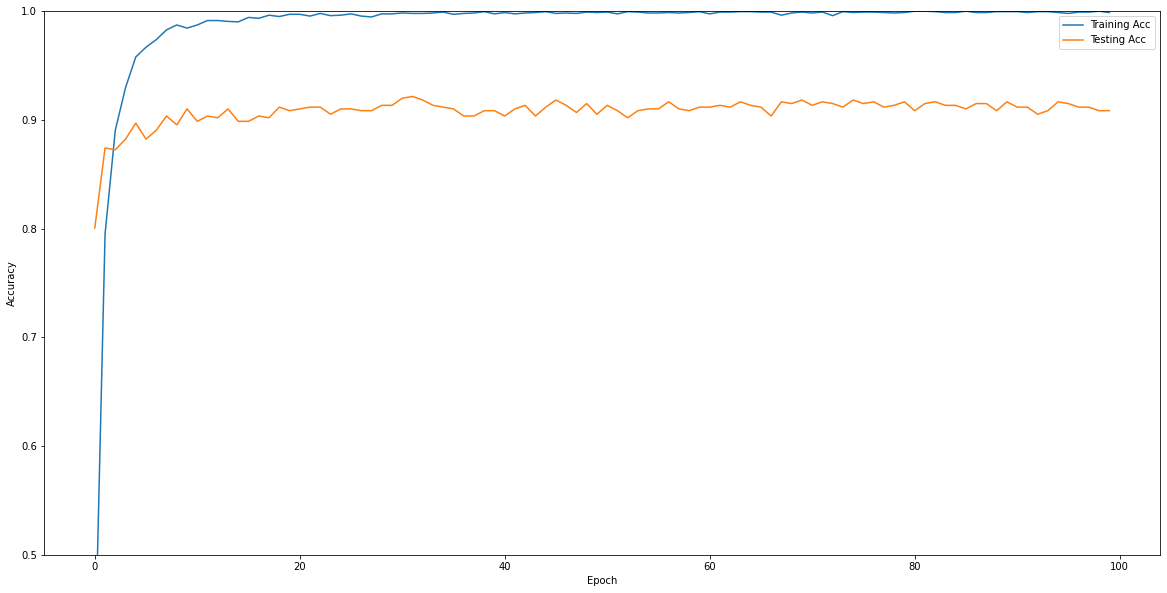

In [ ]:
import keras
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'],label='Testing Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower_right')

test_loss, test_acc = model.evaluate(test_flow)

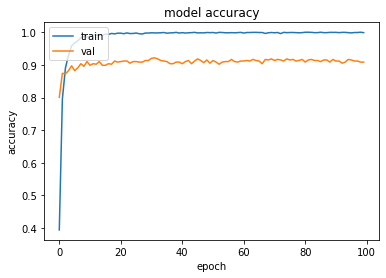

<Figure size 432x288 with 0 Axes>

In [ ]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig("performance_caltech101.png")